*Make sure to run the whole notebook before beginning from the `Runtime -> Run all` menu item.*

In [399]:
import numpy as np
from scipy import signal
from scipy.io import wavfile
from math import ceil
import matplotlib.pyplot as plt
from IPython.display import Audio
import ipywidgets as widgets

# Methods of Audio Analysis in Python - Lesson 2
# Cepstral Analysis, Harmonics and the Mel-scale

In part 1 of our course we learned how sound is digitised via a sampling process and that in order to effectively study such data we should transform it into the frequency domain with the Discrete Fourier Transform applied to short segments, called windows, of the original audio. This resulted in the so-called spectrogram that is an extremely useful tool for analysing any data with strong oscillatory behaviour.

In this notebook we'll focus on an important feature of natural sounds (or waves in general): harmonics. Imagine you try to sing a single note perfectly, say F#. Based on what we learnt last time you might expect the spectrogram of such a sound to show a bright line at the corresponding frequency (which is about 370 Hz). However, let's see what happens in practice.

## Cepstrum

First we'll load the wav file with `scipy.io.wavfile.read` which returns the sampling rate and the audio file as a numpy array with shape *`(n_samples, n_channels)`*. Our clip happens to have been recorded in stereo, so to make things simple we just focus on one of the channels (sometimes you might want to merge channels via e.g. averaging).

In [400]:
# Recording courtesy of freesound.org.
# Licensed under the Creative Commons 0 license
# https://creativecommons.org/publicdomain/zero/1.0/
sr, note = wavfile.read('audio/note.wav')
# Normalise
note = note / np.abs(note).max()
print(f'Successfully read audio with sampling rate {sr} Hz, {note.shape[1]} channels and length {note.shape[0] / sr:.1f} s.')

Successfully read audio with sampling rate 44100 Hz, 2 channels and length 2.5 s.


Let's listen to the clip.

In [401]:
# note that we need the transpose since IPython and SciPy use the opposite convention for the array shape
Audio(note.T, rate=sr)

Next we compute the spectrogram. This should be familiar to you by now. We use mostly the default settings and we restrict ourselves to only the left channel.

In [402]:
window_len = 4096
window_overlap = window_len // 1.2
f, t, Sxx = signal.spectrogram(note[:, 0], sr, nperseg=window_len, noverlap=window_overlap, mode='magnitude')

In [403]:
# As mentioned in lecture 1, it is usually helpful to convert to
# the logarithmic decibel scale.
Sxx_dB = 10*np.log10(Sxx / np.max(Sxx))

def plot(y_UB):
    fig, ax = plt.subplots(figsize=(12, 5))
    p = ax.pcolormesh(t, f, Sxx_dB, cmap='magma', shading='auto',
                      vmin=-50, vmax=0)
    ax.set_ylim(0, y_UB)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title('Spectrogram of vocalised F#')
    fig.colorbar(p, label='dBFS')
    plt.show()

widgets.interact(plot, y_UB=widgets.IntSlider(value=22000, min=500, max=22000,
                                             description='Max frequency'));

interactive(children=(IntSlider(value=22000, description='Max frequency', max=22000, min=500), Output()), _dom…

Now, by using the slider zoom all the way in to see the expected bright line at roughly 370 Hz. What else do you see? It seems there is not just one, but many bright lines! And they seem to form a distinct pattern which attenuates the higher up in frequency you go. These additional lines are called **harmonics** (or harmonic frequencies) of the **fundamental frequency**, also known as the **first harmonic**, which is the lowest dominant frequency. We usually denote the fundamental frequency by $f_{0}$ and the subsequent harmonics by $f_{1}, f_{2},\ldots$ (i.e. somewhat confusingly the *second* harmonic, the *third* harmonic, etc.). It turns out, in fact, that the harmonics are *integer multiples* of the fundamental frequency, so for example the second harmonic (also called the first overtone) satisfies $f_{1} = 2*f_{0}$. Verify this in the above spectrogram.

We won't go further into the physics of *why* such harmonics are formed in the first place, but in short it is the result of the sound waves bouncing around in your vocal tract -- the same effect can be observed with musical instruments. This phenomenon makes the sound *richer* (if you want to try it out you should by now have all the tools you need to generate a synthetic note with the desired number of harmonics and then play it out with `IPython.display`). In general, the harmonic structure of a sound signal depends heavily on the *physical properties* of the generating object (vocal tract, musical instrument, gearbox etc.) and in particular changes in these properties result in changes in the harmonic structure of the generated sound. It is also possible to end up with non-integer multiples of $f_{0}$ (**partial tones**), which further complicates matters. It is also possible for the fundamental frequency to be missing while its harmonics are still present. This happens with e.g. some musical instruments. All in all, understanding the structure of the cepstrum can provide a lot of deep information about the signal and therefore we want a systematic method of studying it. *(gearbox)*

Our observations so far relied on inspection by eye which is not very rigorous nor reliable. How do we quantify and measure the presence of such structures? To make things easier, let's compute the DFT on the whole clip (so in a very rough sense we average the spectrogram over time, though it's not quite equivalent):

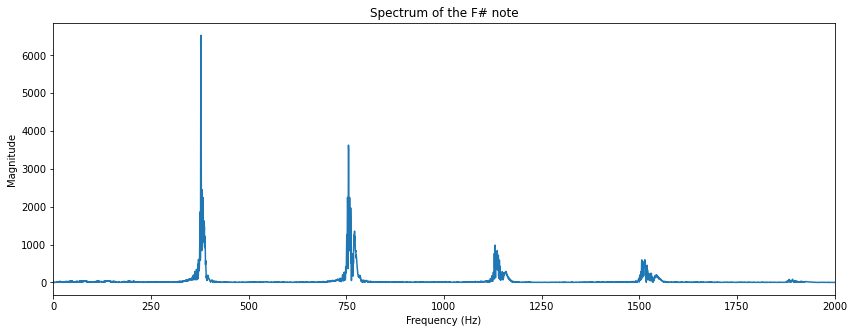

In [404]:
note_spec = np.abs(np.fft.rfft(note[:,0]))
x = np.fft.rfftfreq(2*len(y), d=1./sr)[:-1]

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(x, note_spec)
ax.set_xlim(0, 2000)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_title('Spectrum of the F# note')
plt.show()

Now we can clearly distinguish the dominant pattern along with some mild noise around the various harmonics. If we are given a bunch of more complicated audio clips, how might we go about detecting this kind of structure? Well, it is a *periodic* pattern, i.e. it repeats with a specific *frequency*. And what's our tool to study the frequency content of a function? That's right, the Fourier transform! So now we want to apply FFT on the already transformed note audio. For various reasons, it is helpful to take logarithms first (to make the attenuated peaks more visible, for one):

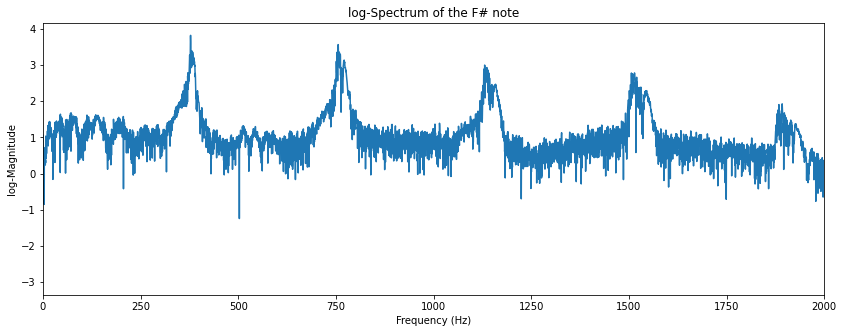

In [405]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(x, np.log10(note_spec))
ax.set_xlim(0, 2000)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('log-Magnitude')
ax.set_title('log-Spectrum of the F# note')
plt.show()

Now we can actually zoom out a bit since taking the logarithm allows us to see what happens in the higher end of the spectrum as well:

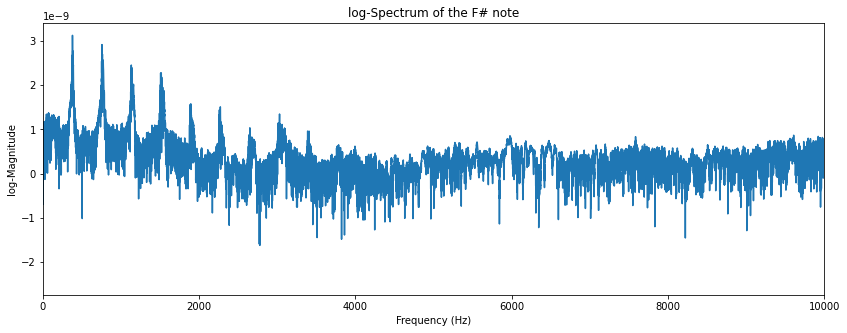

In [406]:
# We work with the power spectrum by taking the absolute square of the FFT,
# by the laws of logarithms this is equivalent to multiplying by two.
# For the sake of consistency we also apply a normalisation factor
normalisation = 2 / (sr * len(note_spec))
note_logspec = normalisation * np.log10(note_spec)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(x, note_logspec)
ax.set_xlim(0, 10000)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('log-Magnitude')
ax.set_title('log-Spectrum of the F# note')
plt.show()

Found peaks at 2.6, 5.3, 7.9 ms.


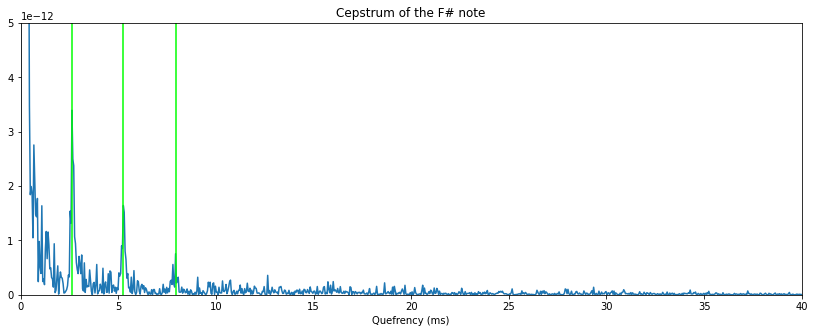

In [407]:
note_ceps = np.abs(np.fft.rfft(note_logspec)) ** 2
que = np.fft.rfftfreq(len(note_logspec), d=np.diff(x)[0])
# We scale to ms for convenience
que *= 1000

# Find the indices of the peaks in the cepstrum
peak_idx = signal.find_peaks(note_ceps, prominence=7e-13, width=2, rel_height=0.8)[0]
# For technical reasons we exclude peaks in the very beginning of the cepstrum:
idx_to_exclude = np.argmin(que < 1.5)
peak_idx = peak_idx[peak_idx > idx_to_exclude]
peak_str = ', '.join([f'{s:.1f}' for s in que[peak_idx]])
print(f'Found peaks at {peak_str} ms.')

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(que, note_ceps)
for ix in peak_idx:
    ax.axvline(que[ix], 0, 5000, color='lime')
ax.set_xlim(0, 40)
ax.set_ylim(0, 5e-12)
ax.set_xlabel('Quefrency (ms)')
ax.set_ylabel('')
ax.set_title('Cepstrum of the F# note')
plt.show()

What we end up with is called the **cepstrum** (a play on words on the *spec*trum), where the $x$-axis is now back in the time domain. It is, however, not the same time axis as with the original waveform. Instead this axis is related to the reciprocal of the periods in the log-spectrum (and since the spacings are in Hz then we end up with units in seconds) and we call it the **quefrency**-axis(from *frequ*ency).

For technical reasons the cepstrum blows up close to 0 so we typically ignore these values and look for the highest subsequent peak. In the above we've used the versatile function `scipy.signal.find_peaks` to find the location of these peaks. Note that we've also scaled the quefrencies to be in the units of milliseconds. If we now look at the reciprocal of the first peak at 0.0026 s then we obtain
$$\frac{1}{0.0026~\mathrm{s}}\approx 384~\mathrm{Hz}.$$
This is very close to the fundamental frequency $f_{0}$ (recall that we took the FFT over the whole clip so there is some distortion due to that)!

> Exercise: Why is the first peak in the cepstrum at $f_{0}$?

Since the harmonics occur at integer multiples of $f_{0}$ then the spacings between them are of course also equal to $f_{1}-f_{0}=2f_{0}-f_{0}=f_{0}$. Now try to think about where the following peaks at 5.3 and 7.9 come from.

In summary, the cepstrum is essentially the Fourier transform of the log-power (or magnitude, depends on what normalisation you wish to use) spectrum. By analysing it we can figure out for example the fundamental frequency of an audio signal and other information about the periodicities of the spectrum. This can of course be extended to windowed signals just like we did with the spectrogram. Thus we would end up with a **cepstrogram**. You can think of it roughly as taking FFTs along the frequency-axis (the $y$-axis) in the spectrogram. We'll see an example of this later, but first we'll take a look at another useful application of the cepstrum.

## Spectral envelope

As we've seen above, even for a clean recording of a simple sound the spectrogram starts to look quite messy. Analysing the structure of peaks in the cepstrum is one way to extract information from among the noise. Sometimes we would like to study the spectrum itself more carefully, but without getting distracted by the noise. In other words, we are interested in finding a *smooth approximation* of the spectrum, which retains the important features of the true spectrum (typically peaks' heights and gaps up to some desired resolution). This approximation is known as the **spectral envelope**. If you understand how (discrete) Fourier transforms work then it should be fairly straightforward to see how we can obtain such an approximation from the cepstrum. If not, don't worry, as we'll go through it together below.

One of the key properties of Fourier transform is that it is invertible. Recall from the previous lesson that for our transformed sequence $\langle X_{k}\rangle$ the higher coefficients ($k$ is large) correspond to higher frequencies. So let's do a small trick: if we are only interested in the general shape of the curve and not the fine-grained details, then let's ignore the higher frequency components and retain the lower ones. We can then apply the inverse transform to this truncated sequence and we should end up with a nice approximation of the spectral envelope. The cut-off point is a parameter that you have to adjust based on how much detail you have to preserve. This is rather easy to do with `np.fft.irfft`.

> Aside: To make things easier we use the full complex cepstrum (i.e. keeping the phase), so that the inversion is straight forward. If for some reason you had access only to the magnitude cepstrum, then you would have to estimate the phase somehow before inverting. A popular method for this is the [Griffin--Lim algorithm](https://www.semanticscholar.org/paper/Signal-estimation-from-modified-short-time-Fourier-Griffin-Lim/14bc876fae55faf5669beb01667a4f3bd324a4f1)

In [408]:
# Recall that note_logspec is normalised
note_cceps = np.fft.rfft(note_logspec)

def plot(cc_UB):
    # We use the n parameter of irfft() to get back a sequence of the same
    # length as our original log-spectrum while only using the first cc_UB of them.
    # This is equivalent to setting the values after index cc_UB in note_cceps to zero.
    spec_envelope = np.fft.irfft(note_cceps[:cc_UB], n=len(note_logspec))
    
    fig, (ax1, ax2) = plt.subplots(figsize=(14, 10), nrows=2)
    ax1.plot(x, note_logspec)
    ax1.plot(x, spec_envelope)

    ax1.set_ylabel('log-Magnitude')
    ax1.set_title('log-Spectrum of the F# note')
    ax2.set_ylabel('Magnitude')
    ax2.set_title('Spectrum of the F# note')
    #ax2.set_ylim(0, 1e)
    ax2.plot(x, note_spec)
    ax2.plot(x, 10 ** (spec_envelope/normalisation))
    for ax in [ax1, ax2]:
        ax.set_xlabel('Frequency (Hz)')
        ax.set_xlim(0, 10000)
    plt.show()

widgets.interact(plot, cc_UB=widgets.IntSlider(value=150, min=5, max=10000,
                                             description='Max cepstral coefficient'));

interactive(children=(IntSlider(value=150, description='Max cepstral coefficient', max=10000, min=5), Output()…

You can adjust the cutoff point for the number of cepstral coefficients to keep. Notice that here we are analysing the spectrum of a rather long clip instead of a single FFT-window. Hence the spectrum is quite complicated and you need to keep quite a few coefficients to obtain a good approximation. When working with typical short windows then usually around 13 to 20 coefficients is plenty. This also allows you to *encode* the spectrum into a much smaller representation.

## Mel-scale and MFCCs

In some applications it has been observed that scaling the frequency-axis to more closely resemble humans' perception of sound offers improved performance. There have been many attempts to do this in the history of audio analysis, but the most dominant way nowadays is the **Mel-scale**. Cepstrum coefficients computed after this scaling are called **Mel-frequency cepstral coefficients** (MFCC) and they have become one of the go-to features in audio analysis. Many ML and audio analysis libraries contain simple methods for extracting MFCC (e.g. TensorFlow, PyTorch, librosa) ready to be used as features in your models. However, care should be taken before blindly feeding these as your model inputs. As we will learn below, the Mel-scale promotes certain frequencies and blends together frequencies in the lower part of the spectrum resulting in some information being lost or distorted. You should carefully think what are the characteristics of the sound that you are trying to understand in your analysis and decide on the most suitable features based on that. We have observed that the Mel-scaling actually resulted in worse performance in some industrial applications, where the crucial information tended to lie in the low frequency range.

<http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/>
<https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html>

## Where next?

## Summary

In this lecture we learned how to uncover hidden (non-obvious) structure in the audio signal by studying the periodic components of the frequency distribution of the input wave. In particular, we saw that many natural sounds consist of a fundamental frequency and its integer multiples, the harmonics. This pattern can be revealed by looking at the cepstrum and looking for peaks, which we expect to occur at the reciprocals of the dominant frequency spacings of the spectrum. Finally, mfcc..

In the next lesson we'll learn another useful tool to extract structure from audio files (or from any type of sequences). The tool is called self-similarity and it approaches this problem from a completely different point of view. See you there!

## Further reading
- homomorphic systems
- https://vlab.amrita.edu/?sub=3&brch=164&sim=615&cnt=1
- http://flothesof.github.io/cepstrum-pitch-tracking.html
- https://people.engr.tamu.edu/rgutier/web_courses/csce630_f14/l9.pdf
- https://sensemore.io/what-is-cepstral-analysis/
- https://surveillance7.sciencesconf.org/conference/surveillance7/01_a_history_of_cepstrum_analysis_and_its_application_to_mechanical_problems.pdf
